#**Hyperparameters Optimized Deep Learning Models for Electrocardiogram Signals Classification: Performance Evaluation Based on the MIT-BIH Dataset**

In [ ]:
! pip install wfdb

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import itertools
import wfdb
from datetime import datetime

import IPython
import IPython.display
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

import shutil
import posixpath

from wfdb import processing

import time
import random

import pandas as pd
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn import tree
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras.models import Model

from scipy.signal import resample

import warnings
warnings.filterwarnings('ignore')

!pip install opendatasets
import opendatasets as od

!pip install kaggle

from sklearn.utils import resample

import imblearn
from imblearn.over_sampling import SMOTE

import tqdm, re, sys

from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense, LSTM, Dropout, Bidirectional
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.layers import Layer, SpatialDropout1D

!pip install -q -U keras-tuner
import kerastuner as kt
import keras_tuner
from kerastuner.tuners import RandomSearch

from keras import backend as K

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.1 MB/s 


In [ ]:
os.getcwd()

'/content'

In [ ]:
"""
   Obtain the MITBIH Dataset from kaggle website:
"""
os.environ['KAGGLE_USERNAME'] = "edgariyasele" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file
#!kaggle datasets download -d kaggle kernels pull polomarco/ecg-classification-cnn-lstm-attention-mechanism
!kaggle datasets download -d polomarco/mitbih-with-synthetic
!kaggle datasets download -d shayanfazeli/heartbeat

## Unzip the downloaded data:
from zipfile import ZipFile
zf = ZipFile('/content/heartbeat.zip', 'r')
zf.extractall('/content')
zf.close()

 94% 139M/148M [00:01<00:00, 133MB/s]
100% 148M/148M [00:01<00:00, 120MB/s]
 92% 91.0M/98.8M [00:00<00:00, 99.6MB/s]
100% 98.8M/98.8M [00:00<00:00, 110MB/s] 


In [ ]:
"""
   Load the Data:
"""
# loading all data files into memory
start = time.time()

data_mitbih_train = pd.read_csv('/content/mitbih_train.csv', header=None)
data_mitbih_test = pd.read_csv('/content/mitbih_test.csv', header=None)

end = time.time()
print('Time taken: %.3f seconds' % (end-start))

print('Data loaded........')

Time taken: 8.672 seconds
Data loaded........


In [ ]:
"""
   Visualize the MITBIH Train Data:
"""
print(data_mitbih_train.info())
print(data_mitbih_train.shape)
print(data_mitbih_train.describe())
data_mitbih_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
None
(87554, 188)
                0             1             2             3             4    \
count  87554.000000  87554.000000  87554.000000  87554.000000  87554.000000   
mean       0.890360      0.758160      0.423972      0.219104      0.201127   
std        0.240909      0.221813      0.227305      0.206878      0.177058   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.921922      0.682486      0.250969      0.048458      0.082329   
50%        0.991342      0.826013      0.429472      0.166000      0.147878   
75%        1.000000      0.910506      0.578767      0.341727      0.258993   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                5             6             7             8             9    \
count  87554.000000  87554.000000  87554

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [ ]:
"""
   Visualize the MITBIH Test Data:
"""
print(data_mitbih_test.info())
print(data_mitbih_test.shape)
print(data_mitbih_test.describe())
data_mitbih_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB
None
(21892, 188)
                0             1             2             3             4    \
count  21892.000000  21892.000000  21892.000000  21892.000000  21892.000000   
mean       0.894410      0.761902      0.426627      0.221596      0.201676   
std        0.234560      0.218659      0.228572      0.208711      0.177727   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.924260      0.683366      0.251197      0.050505      0.082873   
50%        0.990431      0.828996      0.432777      0.167630      0.147642   
75%        1.000000      0.912319      0.583991      0.347092      0.259211   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                5             6             7             8             9    \
count  21892.000000  21892.000000  21892.

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [ ]:
"""
   How many classes are there in each dataset:
"""
# The MIT dataset has 5 clases; 0 = N (Normal Beat); 1 = S (Supraventricular premature beat); 2 = V (Premature ventricular contraction);
# 3 = F (Fusion of ventricular and normal beat); 4 = Q (Unclassifiable beat)

# MITBIH Classes:
data_mitbih_train[187].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

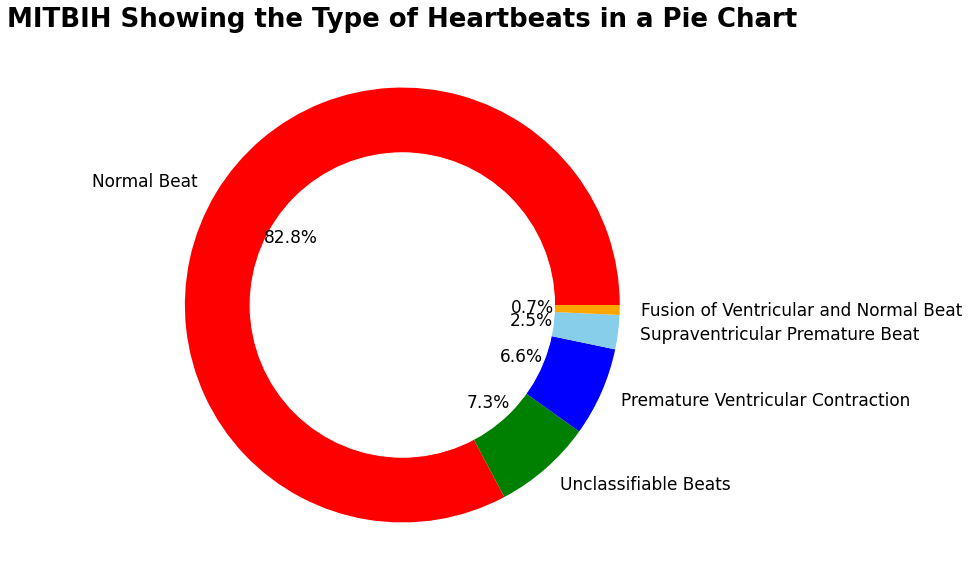

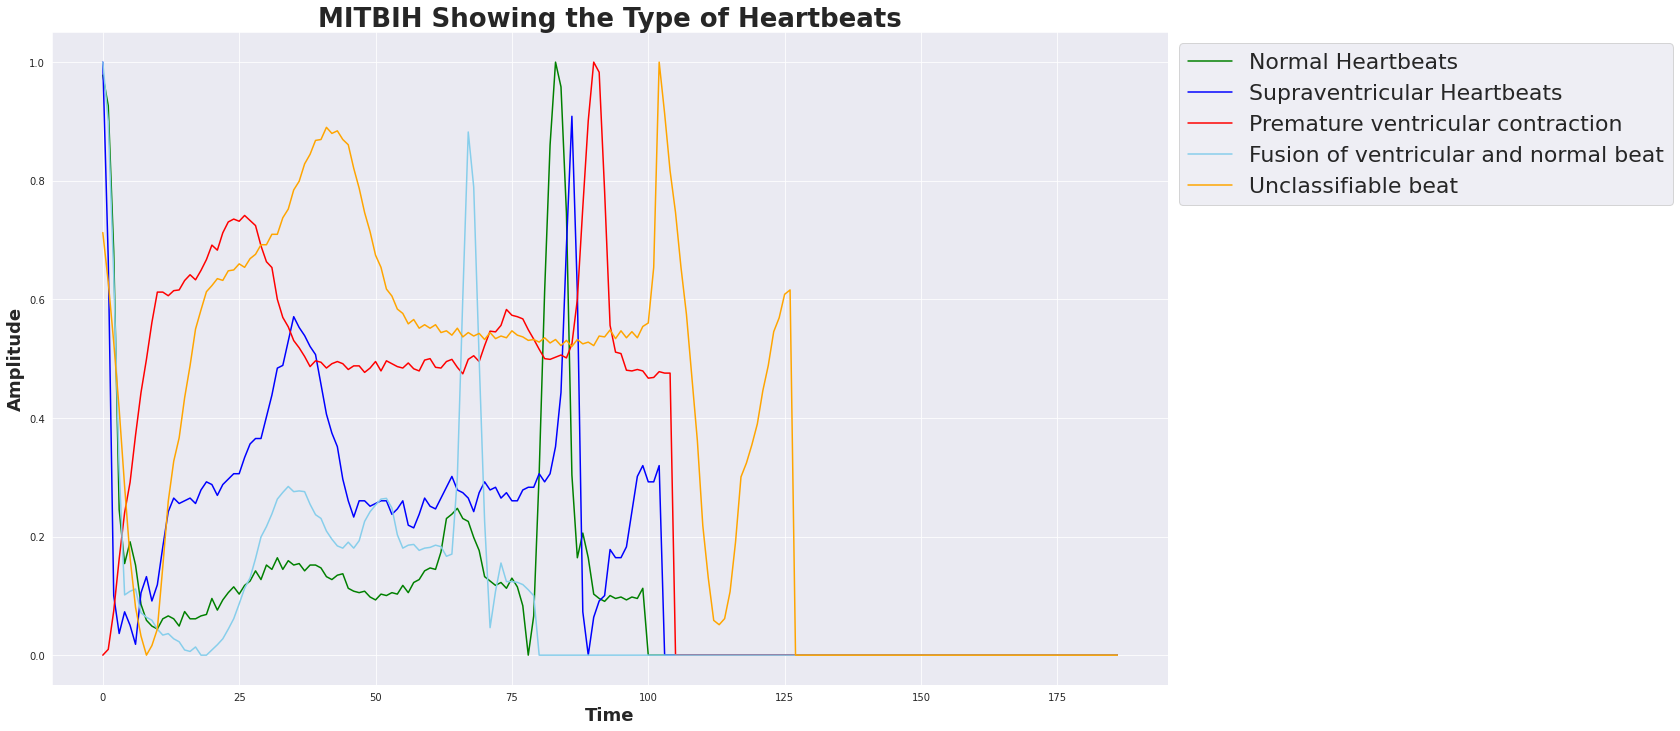

In [ ]:
"""
   Exploratory Data Analysis (EDA): - MITBIH
"""
## Rename the last column as 'class'
data_mitbih_train.rename(columns={187: 'class'}, inplace=True)

# Setting Dictionary to define the type of Heartbeat for both datasets
MIT_Outcome = {0. : 'Normal Beat',
               1. : 'Supraventricular premature beat',
               2. : 'Premature ventricular contraction',
               3. : 'Fusion of ventricular and normal beat',
               4. : 'Unclassifiable beat'}

data_mitbih_train['label'] = data_mitbih_train.iloc[:, -1].map(MIT_Outcome)

## Plot the data:

plt.figure(figsize = (20, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(data_mitbih_train['class'].value_counts(), labels=['Normal Beat', 'Unclassifiable Beats', 'Premature Ventricular Contraction',
                                                   'Supraventricular Premature Beat', 'Fusion of Ventricular and Normal Beat'],
        colors=['red', 'green', 'blue', 'skyblue', 'orange'], autopct = '%1.1f%%', textprops={'fontsize': 17, })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('MITBIH Showing the Type of Heartbeats in a Pie Chart', size = 26, fontweight='bold')
plt.savefig('MITBIH Showing the Type of Heartbeats in a Pie Chart.png')
plt.show()

## Plot the Data - 2

# making the class labels for the dataset
data_0 = data_mitbih_train.iloc[0, 0:187]
data_1 = data_mitbih_train[data_mitbih_train['class'] == 1]
data_2 = data_mitbih_train[data_mitbih_train['class'] == 2]
data_3 = data_mitbih_train[data_mitbih_train['class'] == 3]
data_4 = data_mitbih_train[data_mitbih_train['class'] == 4]

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(data_0, color='green', label='Normal Heartbeats')
ax.plot(data_1.iloc[0, 0:187], color='blue', label='Supraventricular Heartbeats')
ax.plot(data_2.iloc[0, 0:187], color='red', label='Premature ventricular contraction')
ax.plot(data_3.iloc[0, 0:187], color='skyblue', label='Fusion of ventricular and normal beat')
ax.plot(data_4.iloc[0, 0:187], color='orange', label='Unclassifiable beat')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.text(0.0, 0.1, " ", fontsize=22, transform=ax.transAxes)
ax.set_xlabel('Time', weight='bold').set_fontsize('18')
ax.set_ylabel('Amplitude', weight='bold').set_fontsize('18')
ax.set_title('MITBIH Showing the Type of Heartbeats', size = 26, fontweight='bold')
ax.legend(loc = 'best', bbox_to_anchor = (1.0, 1.0), ncol = 1, frameon=True, fontsize = '22')
plt.savefig('MITBIH Showing the Type of Heartbeats.png')

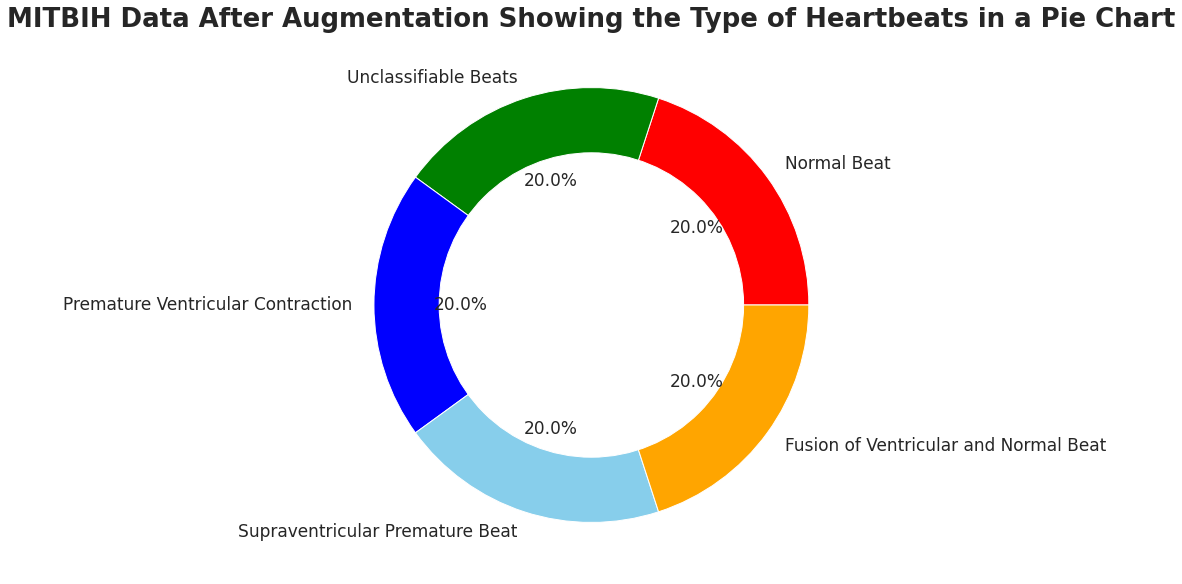

In [ ]:
"""
   Data Augmentation - MITBIH

   Since our data in biased, we need to use data argumentation on it so that we can remove bias from data and make equal distributions.
"""

data_1_resample = resample(data_1, n_samples=20000,
                           random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=20000,
                           random_state=123, replace=True)
data_3_resample = resample(data_3, n_samples=20000,
                           random_state=123, replace=True)
data_4_resample = resample(data_4, n_samples=20000,
                           random_state=123, replace=True)
data_0 = data_mitbih_train[data_mitbih_train['class'] == 0].sample(n=20000, random_state=123)

train_dataset_mitbih = pd.concat([data_0, data_1_resample, data_2_resample, data_3_resample,
                                  data_4_resample])

## Plot the data after Augmentation:

plt.figure(figsize = (20, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(train_dataset_mitbih['class'].value_counts(), labels=['Normal Beat', 'Unclassifiable Beats', 'Premature Ventricular Contraction',
                                                   'Supraventricular Premature Beat', 'Fusion of Ventricular and Normal Beat'],
        colors=['red', 'green', 'blue', 'skyblue', 'orange'], autopct = '%1.1f%%', textprops={'fontsize': 17, })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title('MITBIH Data After Augmentation Showing the Type of Heartbeats in a Pie Chart', size = 26, fontweight='bold')
plt.savefig('MITBIH Data After Augmentation Showing the Type of Heartbeats in a Pie Chart.png')
plt.show()

In [ ]:
"""
   Make X & Y Variables for MITBIH Dataset and Slice it:
"""
target_train = train_dataset_mitbih['class']

target_test = data_mitbih_test[187]
target_train.unique()

y_train = to_categorical(target_train)
y_test = to_categorical(target_test)

# Data Splicing:
# This stage involves the data split into train & test sets. The training data will be used for training our model,
# and the testing data will be used to check the performance of model on unseen dataset.

# making train & test splits
X_train = train_dataset_mitbih.iloc[:, :-2].values
X_test = data_mitbih_test.iloc[:, :-1].values
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100000, 187)
(21892, 187)
(100000, 5)
(21892, 5)


In [ ]:
"""
   Compile and Build the Maachine Learning Random Forest and Support Vector Machine Models for Comparison:
"""

# Define Some Metrics:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Time Taken: 104.514 seconds
Accuracy on test data is: 0.9672
Time Taken: 1.127 seconds
Accuracy: 0.9671569523113466
F1 score: 0.9743252664275995
Recall: 0.9671569523113466
Precision: 0.982039571762725

 clasification report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.86      0.72      0.78       556
           2       0.97      0.91      0.94      1448
           3       0.80      0.69      0.74       162
           4       0.99      0.96      0.97      1608

   micro avg       0.98      0.97      0.97     21892
   macro avg       0.92      0.85      0.88     21892
weighted avg       0.98      0.97      0.97     21892
 samples avg       0.97      0.97      0.97     21892


 confussion matrix:
 [[18004    66    29    11     8]
 [  156   398     1     0     1]
 [  106     1  1321    16     4]
 [   38     0    13   111     0]
 [   66     0     4     0  1538]]
Normalized confusion matrix


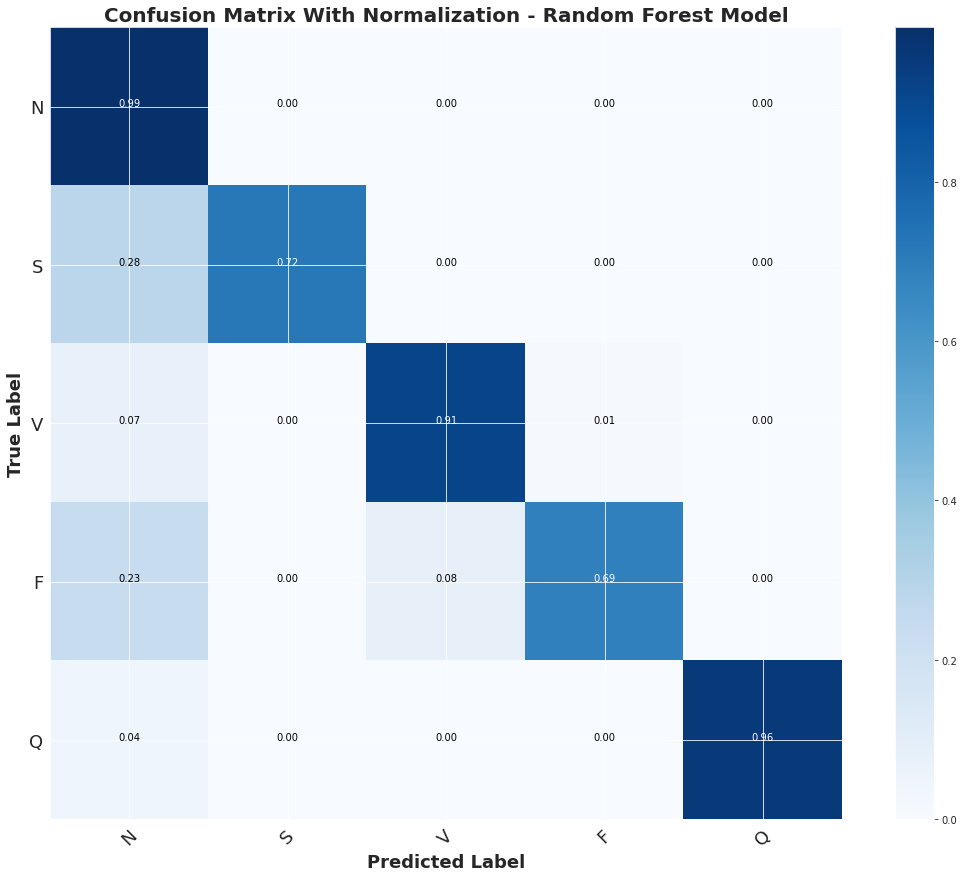

In [ ]:
"""
   Model 1 - Random Forest (RF) Classifier:
   Here, we use Random Forest Classifier to fit to our training dataset & predict results.
"""
# instantiate the classifier and fit to training data
start = time.time()

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

# viewing params of random forest
rf.get_params()

all_models = list()
performance_all = {}

# Evaluate the model
print('Accuracy on test data is: %.4f' % rf.score(X_test, y_test))

# making predictions on test set
start = time.time()

y_pred_rf = rf.predict(X_test)

end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('F1 score:', f1_score(y_test, y_pred_rf, average='weighted'))
print('Recall:', recall_score(y_test, y_pred_rf, average='weighted'))
print('Precision:', precision_score(y_test, y_pred_rf, average='weighted'))
print('\n clasification report:\n', classification_report(y_test, y_pred_rf))
print('\n confussion matrix:\n', confusion_matrix(y_test.argmax(axis=1), y_pred_rf.argmax(axis=1)))

performance_all['RF_Model'] = accuracy_score(y_test, y_pred_rf), f1_score(y_test, y_pred_rf, average='weighted'), recall_score(y_test, y_pred_rf, average='weighted'), precision_score(y_test, y_pred_rf, average='weighted')

model1 = rf
all_models.append(model1)

# Plot Model's Confusion Matrix:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', weight='bold').set_fontsize('18')
    plt.xlabel('Predicted Label', weight='bold').set_fontsize('18')
    plt.savefig('Confusion Matrix for Random Forest Model.png')

cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_rf.argmax(axis=1))
plt.figure(figsize=(15, 12))
plot_confusion_matrix(cf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      normalize = True, title='Confusion Matrix With Normalization - Random Forest Model')
plt.show()

Accuracy on test data is: 0.8423
Time Taken: 255.001 seconds
Accuracy: 0.8423168280650466
F1 score: 0.8985948028308774
Recall: 0.8524575187283026
Precision: 0.9624733658194119

 clasification report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     18118
           1       0.38      0.79      0.52       556
           2       0.90      0.89      0.89      1448
           3       0.17      0.91      0.29       162
           4       0.95      0.97      0.96      1608

   micro avg       0.92      0.85      0.88     21892
   macro avg       0.68      0.88      0.71     21892
weighted avg       0.96      0.85      0.90     21892
 samples avg       0.85      0.85      0.85     21892


 confussion matrix:
 [[16799   581    95   602    41]
 [  110   434     4     6     2]
 [  109     9  1274    53     3]
 [   11     0     4   147     0]
 [   40     5     9     1  1553]]
Normalized confusion matrix


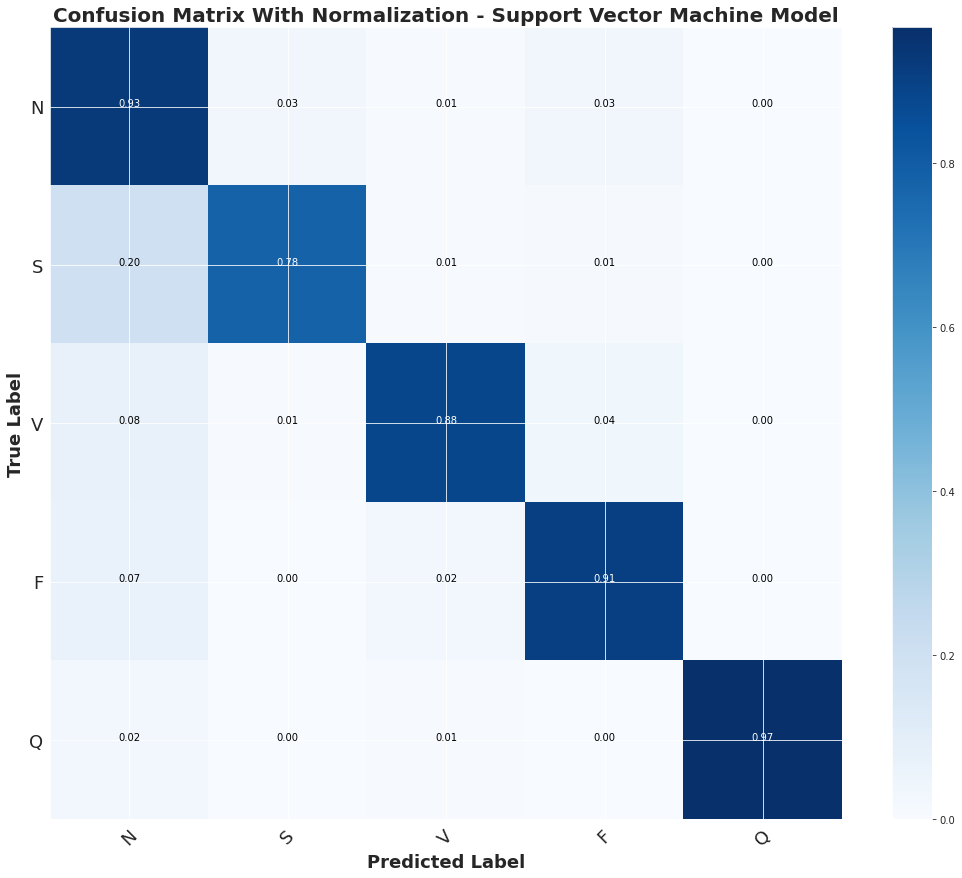

In [ ]:
"""
   Model 2 - Support Vector Machine (SVM):
   Similar to RF Model, we'll fit SVM on our training dataset and check its performance on test data.
"""
# instantiate and fit SVM to train data

svc = SVC()
clf = OneVsRestClassifier(estimator=svc)
clf.fit(X_train, y_train)

# check parameters of SVM
clf.get_params()

# Evaluate the model
print('Accuracy on test data is: %.4f' % clf.score(X_test, y_test))

# making predictions on test set
start = time.time()

y_pred_svc = clf.predict(X_test)

end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

print('Accuracy:', accuracy_score(y_test, y_pred_svc))
print('F1 score:', f1_score(y_test, y_pred_svc, average='weighted'))
print('Recall:', recall_score(y_test, y_pred_svc, average='weighted'))
print('Precision:', precision_score(y_test, y_pred_svc, average='weighted'))
print('\n clasification report:\n', classification_report(y_test, y_pred_svc))
print('\n confussion matrix:\n', confusion_matrix(y_test.argmax(axis=1), y_pred_svc.argmax(axis=1)))

performance_all['SVC_Model'] = accuracy_score(y_test, y_pred_svc), f1_score(y_test, y_pred_svc, average='weighted'), recall_score(y_test, y_pred_svc, average='weighted'), precision_score(y_test, y_pred_svc, average='weighted')

model2 = clf
all_models.append(model2)

# Plot Model's Confusion Matrix:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', weight='bold').set_fontsize('18')
    plt.xlabel('Predicted Label', weight='bold').set_fontsize('18')
    plt.savefig('Confusion Matrix for Support Vector Machine Model.png')

cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_svc.argmax(axis=1))
plt.figure(figsize=(15, 12))
plot_confusion_matrix(cf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      normalize = True, title='Confusion Matrix With Normalization - Support Vector Machine Model')
plt.show()

In [ ]:
"""
   Compile, Build, and Perform Hyperparameters Optimization in order to Build the Deep Learning CNN, CNN_BiLSTM, and
   Attention Based CNN_BiLSTM Models:
"""

"""
   Model 3 - Convolutional Neural Network (CNN)

   We will apply the CNN algorithm to our data to generate prediction results. First, we need to reshape our data for CNN.
   We will use 1-dimensional CNN for our model, reshaping our data as per the dimensions of our CNN
"""

"""Note that the timeseries data used here are univariate, meaning we only have one channel per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel using a simple
reshaping via numpy. This will allow us to construct a model that is easily applicable to multivariate time series"""


# Reshape the Data:
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train.shape, X_test.shape

# Compile the CNN Model:
def call_existing_code(hp, optimizer, batch_size, epochs):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=6, activation='relu',
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())

    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=64, kernel_size=6, activation='relu',
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=64, kernel_size=6, activation='relu',
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy', f1_m, precision_m, recall_m])
    return model

def build_model(hp):
    optimizer = hp.Choice("optimizer", ["adam", "sgd"]),
    batch_size = hp.Int('batch_size', 32, 256, step=32),
    epochs = hp.Int('epochs', 10, 100, step=10),

    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(hp, optimizer=optimizer, batch_size=batch_size,
                               epochs=epochs)
    return model

build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective="val_accuracy",
    max_trials=2,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="CNN_MITBIH",
)

# print a summary of the search space:
tuner.search_space_summary()

tuner.search(
    X_train, y_train, validation_split=0.3, epochs = 10,
)

print(tuner.results_summary())

# Get the optimal hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Get the best model:
new_model = tuner.get_best_models()[0]

IPython.display.clear_output()

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hp.get('learning_rate')}, the optimal Optimizer is {best_hp.get('optimizer')},
the optimal batch size for the optimizer is {best_hp.get('batch_size')}, the optimal epoch for the optimizer
is {best_hp.get('epochs')}, and the Best Hyperparameters values are {best_hp.values}.
""")


The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.001, the optimal Optimizer is sgd,
the optimal batch size for the optimizer is 64, the optimal epoch for the optimizer
is 100, and the Best Hyperparameters values are {'optimizer': 'sgd', 'batch_size': 64, 'epochs': 100, 'learning_rate': 0.001}.



Epoch 1/5
2188/2188 [==============================] - 144s 66ms/step - loss: 0.0295 - accuracy: 0.9907 - f1_m: 0.9907 - precision_m: 0.9911 - recall_m: 0.9903 - val_loss: 131.3570 - val_accuracy: 0.3333 - val_f1_m: 0.3332 - val_precision_m: 0.3332 - val_recall_m: 0.3332
Epoch 2/5
2188/2188 [==============================] - 140s 64ms/step - loss: 0.0294 - accuracy: 0.9910 - f1_m: 0.9909 - precision_m: 0.9913 - recall_m: 0.9905 - val_loss: 144.0146 - val_accuracy: 0.3333 - val_f1_m: 0.3332 - val_precision_m: 0.3332 - val_recall_m: 0.3332
Epoch 3/5
2188/2188 [==============================] - 135s 62ms/step - loss: 0.0285 - accuracy: 0.9913 - f1_m: 0.9912 - precision_m: 0.9916 - recall_m: 0.9909 - val_loss: 129.7681 - val_accuracy: 0.3333 - val_f1_m: 0.3332 - val_precision_m: 0.3332 - val_recall_m: 0.3332
Epoch 4/5
2188/2188 [==============================] - 133s 61ms/step - loss: 0.0265 - accuracy: 0.9916 - f1_m: 0.9916 - precision_m: 0.9920 - recall_m: 0.9912 - val_loss: 174.4849 - v

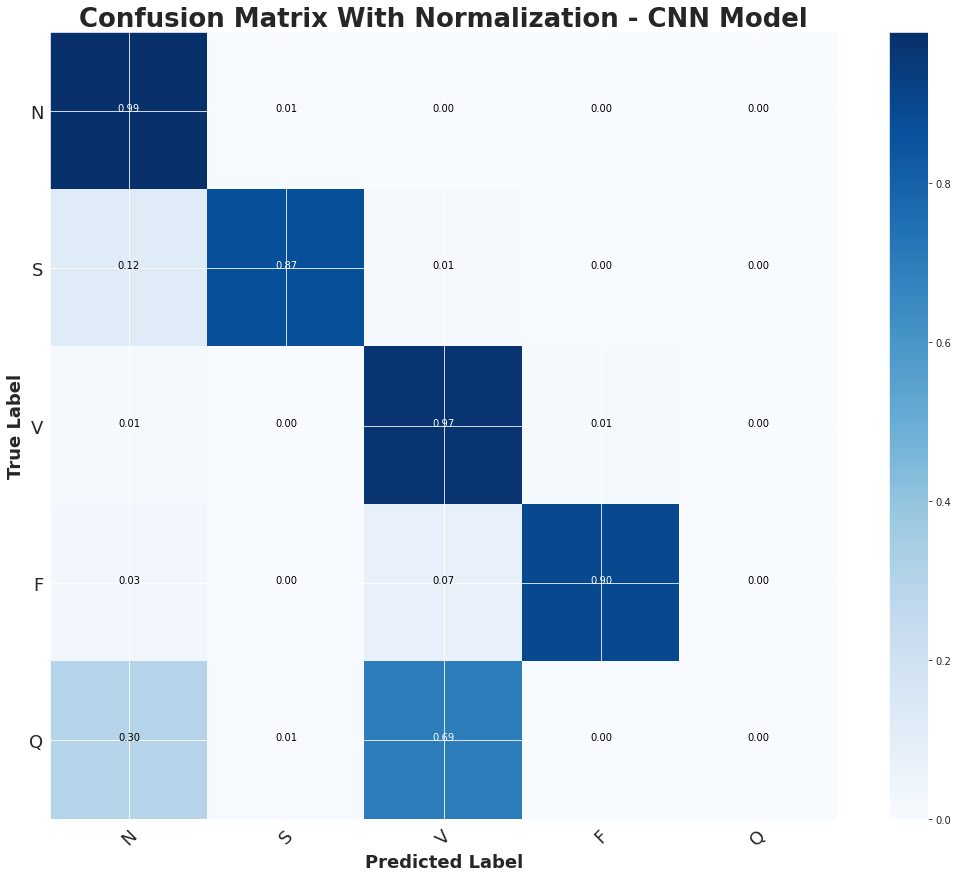

In [ ]:
"""
    Retrain the model:
"""
# Build the model with the best hp.
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_CNN.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    ]

model = new_model

# Fit with the entire dataset.
model.fit(X_train, y_train, validation_split=0.3, epochs=5,
          callbacks=callbacks,
          verbose=1,
          )

performance = {}

# Evaluate the model
performance['CNN_MITBIH'] = model.evaluate(X_test, y_test, verbose = 0)
print("[loss:, accuracy :, f1_m :,  precision_m :, recall_m :]", performance['CNN_MITBIH'])

# Evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy", accuracy)
print("Test F1-Score", f1_score)
print("Test Precision", precision)
print("Test Recall", recall)

# making predictions on test set
start = time.time()
y_pred_CNN = model.predict(X_test)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

#performance_all['CNN_Model'] = accuracy, f1_score, recall_score(), precision_score()

model3 = model
all_models.append(model3)

model3.summary()

keras.utils.plot_model(model3, show_shapes=True)

# Plot Model's Confusion Matrix:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 26, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', weight='bold').set_fontsize('18')
    plt.xlabel('Predicted Label', weight='bold').set_fontsize('18')
    plt.savefig('Confusion Matrix for CNN Model.png')

cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_CNN.argmax(axis=1))
plt.figure(figsize=(15, 12))
plot_confusion_matrix(cf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      normalize = True, title='Confusion Matrix With Normalization - CNN Model')
plt.show()

In [ ]:
"""
   Model 4 - Hybrid CNN and BiLSTM (CNN_BiLSTM):

   Convolutional neural networks excel at learning the spatial structure in input data.
   The data does have a one-dimensional spatial structure in the sequence of words in reviews, and the CNN may be able to
   pick out invariant features for the good and bad sentiment. This learned spatial feature may then be
   learned as sequences by an BiLSTM layer.
   You can easily add a one-dimensional CNN and max pooling layers after the Embedding layer, which then
   feeds the consolidated features to the BiLSTM. You can use a smallish set of 32 features with a small filter
   length of 3. The pooling layer can use the standard length of 2 to halve the feature map size.
"""
# Compile the Model:
def call_existing_code(hp, optimizer, batch_size, epochs):

    model = Sequential()

    model.add(Conv1D(filters=128, kernel_size=6, activation='relu',
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())

    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=64, kernel_size=6, activation='relu',
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=64, kernel_size=6, activation='relu',
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy', f1_m, precision_m, recall_m])
    return model

def build_model(hp):
    optimizer = hp.Choice("optimizer", ["adam", "sgd"]),
    batch_size = hp.Int('batch_size', 32, 256, step=32),
    epochs = hp.Int('epochs', 10, 100, step=10),

    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(hp, optimizer=optimizer, batch_size=batch_size,
                               epochs=epochs)
    return model

build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective="val_accuracy",
    max_trials=2,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="CNN_BiLSTM_MITBIH",
)

# print a summary of the search space:
tuner.search_space_summary()

tuner.search(
    X_train, y_train, validation_split=0.3, epochs = 10,
)

print(tuner.results_summary())

# Get the optimal hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Get the best model:
new_model = tuner.get_best_models()[0]

IPython.display.clear_output()

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hp.get('learning_rate')}, the optimal Optimizer is {best_hp.get('optimizer')},
the optimal batch size for the optimizer is {best_hp.get('batch_size')}, the optimal epoch for the optimizer
is {best_hp.get('epochs')}, and the Best Hyperparameters values are {best_hp.values}.
""")



The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.01, the optimal Optimizer is sgd,
the optimal batch size for the optimizer is 96, the optimal epoch for the optimizer
is 20, and the Best Hyperparameters values are {'optimizer': 'sgd', 'batch_size': 96, 'epochs': 20, 'learning_rate': 0.01}.



Epoch 1/5
2188/2188 [==============================] - 855s 388ms/step - loss: 0.6503 - accuracy: 0.7502 - f1_m: 0.7297 - precision_m: 0.8065 - recall_m: 0.6690 - val_loss: 18.4720 - val_accuracy: 0.2703 - val_f1_m: 0.2758 - val_precision_m: 0.2839 - val_recall_m: 0.2684
Epoch 2/5
2188/2188 [==============================] - 850s 388ms/step - loss: 0.6145 - accuracy: 0.7681 - f1_m: 0.7512 - precision_m: 0.8224 - recall_m: 0.6935 - val_loss: 21.7947 - val_accuracy: 0.1234 - val_f1_m: 0.1127 - val_precision_m: 0.1415 - val_recall_m: 0.0943
Epoch 3/5
2188/2188 [==============================] - 845s 386ms/step - loss: 0.6132 - accuracy: 0.7658 - f1_m: 0.7522 - precision_m: 0.8089 - recall_m: 0.7058 - val_loss: 30.7911 - val_accuracy: 0.2869 - val_f1_m: 0.2946 - val_precision_m: 0.3122 - val_recall_m: 0.2792
Epoch 4/5
2188/2188 [==============================] - 844s 386ms/step - loss: 0.5985 - accuracy: 0.7702 - f1_m: 0.7599 - precision_m: 0.8132 - recall_m: 0.7153 - val_loss: 41.8562 - v

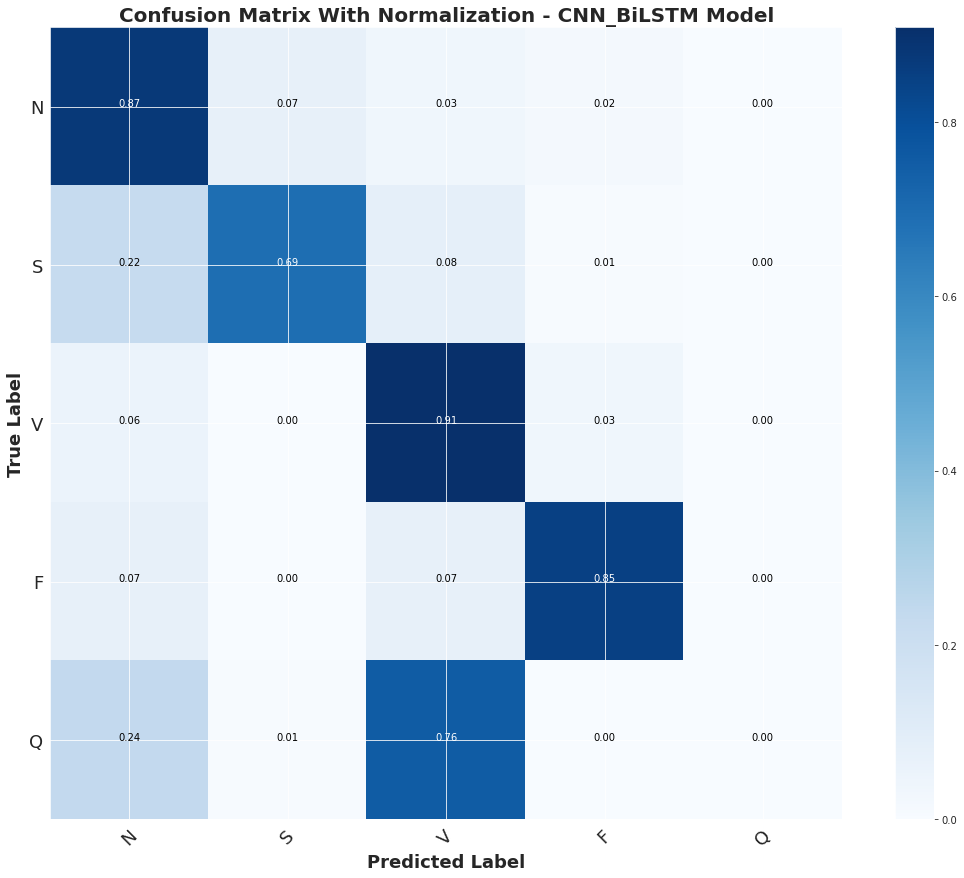

In [ ]:
"""
    Retrain the model:
"""
# Build the model with the best hp.
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_CNN_BiLSTM.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    ]

model = new_model

# Fit with the entire dataset.
model.fit(X_train, y_train, validation_split=0.3, epochs = 5,
          callbacks=callbacks,
          verbose=1,
          )

# Evaluate the model
performance['CNN_BiLSTM_MITBIH'] = model.evaluate(X_test, y_test, verbose = 0)
print("[loss:, accuracy :, f1_m :,  precision_m :, recall_m :]", performance['CNN_BiLSTM_MITBIH'])

# Evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy", accuracy)
print("Test F1-Score", f1_score)
print("Test Precision", precision)
print("Test Recall", recall)

# making predictions on test set
start = time.time()
y_pred_CNN_LSTM = model.predict(X_test)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

model4 = model
all_models.append(model4)

model4.summary()

keras.utils.plot_model(model4, show_shapes=True)

# Plot Model's Confusion Matrix:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', weight='bold').set_fontsize('18')
    plt.xlabel('Predicted Label', weight='bold').set_fontsize('18')
    plt.savefig('Confusion Matrix for CNN_BiLSTM Model.png')

cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_CNN_LSTM.argmax(axis=1))
plt.figure(figsize=(15, 12))
plot_confusion_matrix(cf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      normalize = True, title='Confusion Matrix With Normalization - CNN_BiLSTM Model')
plt.show()

In [ ]:
"""
    The custom Attention Layer:
"""
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

"""
   Model 5 - Hybrid CNN_BiLSTM Network With Attention Layer:
"""
# Compile the Model:
def call_existing_code(hp, optimizer, batch_size, epochs):

    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=6, activation='relu',
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())

    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=64, kernel_size=6, activation='relu',
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=64, kernel_size=6, activation='relu',
                    padding='same', input_shape=(187, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(attention())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy', f1_m, precision_m, recall_m])
    return model

def build_model(hp):
    optimizer = hp.Choice("optimizer", ["adam", "sgd"]),
    batch_size = hp.Int('batch_size', 32, 256, step=32),
    epochs = hp.Int('epochs', 10, 100, step=10),

    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(hp, optimizer=optimizer, batch_size=batch_size,
                               epochs=epochs)
    return model

build_model(keras_tuner.HyperParameters())

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_CNN_BiLSTM_Attention.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
    ]

tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective="val_accuracy",
    max_trials=2,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name="CNN_BiLSTM_Attention_MITBIH",
)

# print a summary of the search space:
tuner.search_space_summary()

tuner.search(
    X_train, y_train, validation_split=0.3, epochs = 10,
)

print(tuner.results_summary())

# Get the optimal hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Get the best model:
new_model = tuner.get_best_models()[0]

IPython.display.clear_output()

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hp.get('learning_rate')}, the optimal Optimizer is {best_hp.get('optimizer')},
the optimal batch size for the optimizer is {best_hp.get('batch_size')}, the optimal epoch for the optimizer
is {best_hp.get('epochs')}, and the Best Hyperparameters values are {best_hp.values}.
""")


The hyperparameter search is complete. The optimal learning rate for the optimizer
is 0.0001, the optimal Optimizer is adam,
the optimal batch size for the optimizer is 128, the optimal epoch for the optimizer
is 20, and the Best Hyperparameters values are {'optimizer': 'adam', 'batch_size': 128, 'epochs': 20, 'learning_rate': 0.0001}.



Epoch 1/5
2188/2188 [==============================] - 470s 213ms/step - loss: 0.0453 - accuracy: 0.9855 - f1_m: 0.9853 - precision_m: 0.9858 - recall_m: 0.9849 - val_loss: 15.8812 - val_accuracy: 0.3333 - val_f1_m: 0.3332 - val_precision_m: 0.3332 - val_recall_m: 0.3332
Epoch 2/5
2188/2188 [==============================] - 465s 213ms/step - loss: 0.0389 - accuracy: 0.9877 - f1_m: 0.9876 - precision_m: 0.9880 - recall_m: 0.9872 - val_loss: 19.3066 - val_accuracy: 0.3268 - val_f1_m: 0.3266 - val_precision_m: 0.3266 - val_recall_m: 0.3266
Epoch 3/5
2188/2188 [==============================] - 466s 213ms/step - loss: 0.0345 - accuracy: 0.9889 - f1_m: 0.9890 - precision_m: 0.9892 - recall_m: 0.9887 - val_loss: 20.4239 - val_accuracy: 0.3311 - val_f1_m: 0.3310 - val_precision_m: 0.3310 - val_recall_m: 0.3310
Epoch 4/5
2188/2188 [==============================] - 469s 214ms/step - loss: 0.0331 - accuracy: 0.9888 - f1_m: 0.9888 - precision_m: 0.9891 - recall_m: 0.9886 - val_loss: 21.1361 - v

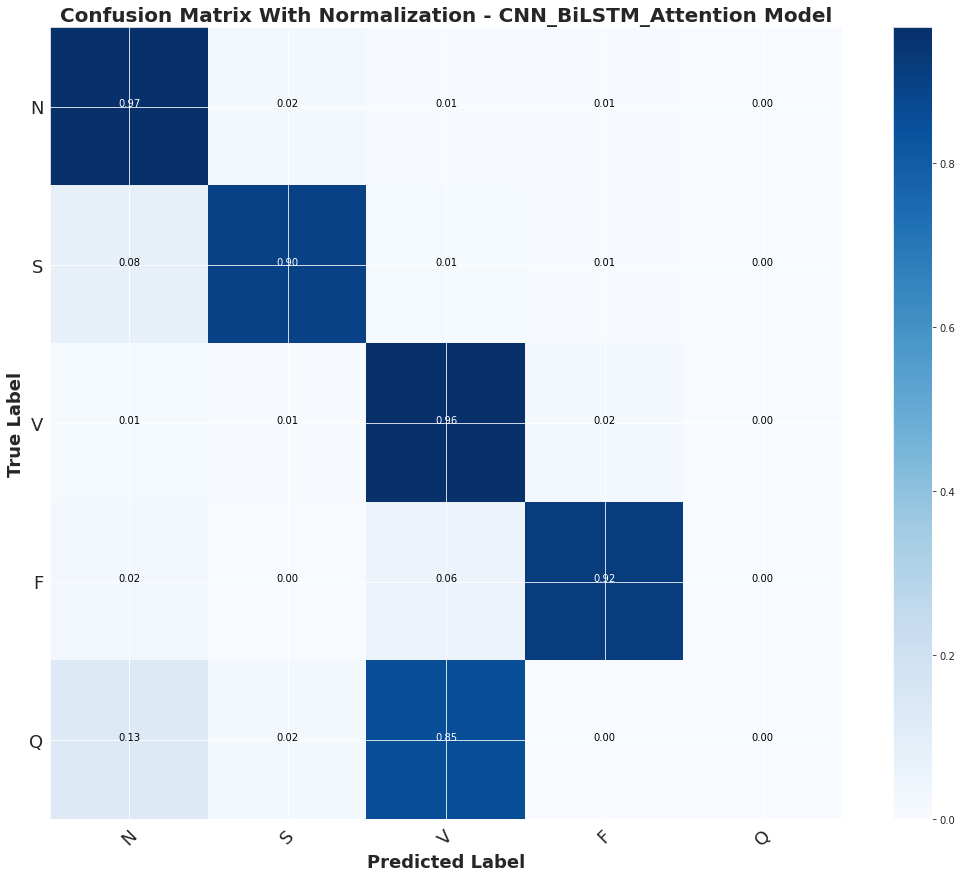

In [ ]:
"""
    Retrain the model:
"""
# Build the model with the best hp.

model = new_model

# Fit with the entire dataset.
model.fit(X_train, y_train, validation_split=0.3, epochs = 5,
          callbacks=callbacks,
          verbose=1,
          )

# Evaluate the model
performance['CNN_BiLSTM_Attention_MITBIH'] = model.evaluate(X_test, y_test, verbose = 0)
print("[loss:, accuracy :, f1_m :,  precision_m :, recall_m :]", performance['CNN_BiLSTM_Attention_MITBIH'])

# Evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy", accuracy)
print("Test F1-Score", f1_score)
print("Test Precision", precision)
print("Test Recall", recall)

# making predictions on test set
start = time.time()
y_pred_CNN_BiLSTM_Attention = model.predict(X_test)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

model5 = model
all_models.append(model5)

model5.summary()

keras.utils.plot_model(model5, show_shapes=True)

# Plot Model's Confusion Matrix:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', weight='bold').set_fontsize('18')
    plt.xlabel('Predicted Label', weight='bold').set_fontsize('18')
    plt.savefig('Confusion Matrix for CNN_BiLSTM_Attention Model.png')

cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_CNN_BiLSTM_Attention.argmax(axis=1))
plt.figure(figsize=(15, 12))
plot_confusion_matrix(cf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      normalize = True, title='Confusion Matrix With Normalization - CNN_BiLSTM_Attention Model')
plt.show()

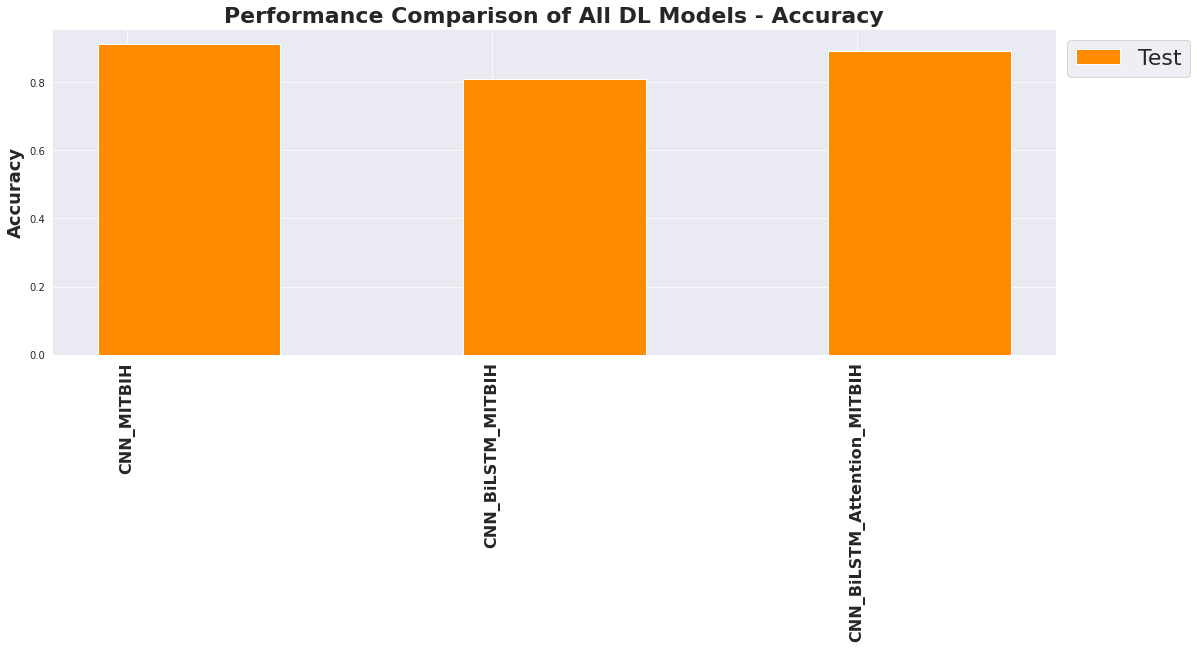

In [ ]:
"""
    Performance ACCURACY:
"""
x = np.arange(len(performance))
width = 0.5
metric_name = 'accuracy'
metric_index = model.metrics_names.index('accuracy')
test_accuracy = [v[metric_index] for v in performance.values()]

plt.figure(figsize=(18, 6))
plt.ylabel("Accuracy", weight='bold').set_fontsize('18')
#plt.bar(x - 0.17, val_accuracy, width, label='Validation')
plt.bar(x + 0.17, test_accuracy, width, label='Test', color = 'darkorange')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=90, size = 16, fontweight='bold')
plt.title('Performance Comparison of All DL Models - Accuracy', size = 22, fontweight='bold')
_ = plt.legend(loc = 2, bbox_to_anchor = (1.0, 1.0), ncol = 1, frameon=True, fontsize = '22')
plt.grid(True)
plt.savefig('Performance Comparison of All DL Models-Accuracy.png')

In [ ]:
"""
    Performance F1-SCORE:
"""
x = np.arange(len(performance))
width = 0.5
metric_name = f1_m
metric_index = model.metrics_names.index('f1_m')
test_accuracy = [v[metric_index] for v in performance.values()]

plt.figure(figsize=(18, 6))
plt.ylabel("F1-Score", weight='bold').set_fontsize('18')
#plt.bar(x - 0.17, val_accuracy, width, label='Validation')
plt.bar(x + 0.17, test_accuracy, width, label='Test', color = 'darkorange')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=90, size = 16, fontweight='bold')
plt.title('Performance Comparison of All DL Models - F1-Score', size = 22, fontweight='bold')
_ = plt.legend(loc = 2, bbox_to_anchor = (1.0, 1.0), ncol = 1, frameon=True, fontsize = '22')
plt.grid(True)
plt.savefig('Performance Comparison of All DL Models-F1-Score.png')

' \n    Performance F1-SCORE:\n'

In [ ]:
"""
    Performance PRECISION:
"""
x = np.arange(len(performance))
width = 0.5
metric_name = precision_m
metric_index = model.metrics_names.index('precision_m')
test_accuracy = [v[metric_index] for v in performance.values()]

plt.figure(figsize=(18, 6))
plt.ylabel("Precision", weight='bold').set_fontsize('18')
#plt.bar(x - 0.17, val_accuracy, width, label='Validation')
plt.bar(x + 0.17, test_accuracy, width, label='Test', color = 'darkorange')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=90, size = 16, fontweight='bold')
plt.title('Performance Comparison of All DL Models - Precision', size = 22, fontweight='bold')
_ = plt.legend(loc = 2, bbox_to_anchor = (1.0, 1.0), ncol = 1, frameon=True, fontsize = '22')
plt.grid(True)
plt.savefig('Performance Comparison of All DL Models-Precision.png')

In [ ]:
"""
    Performance RECALL:
"""
x = np.arange(len(performance))
width = 0.5
metric_name = recall_m
metric_index = model.metrics_names.index('recall_m')
test_accuracy = [v[metric_index] for v in performance.values()]

plt.figure(figsize=(18, 6))
plt.ylabel("Recall", weight='bold').set_fontsize('18')
#plt.bar(x - 0.17, val_accuracy, width, label='Validation')
plt.bar(x + 0.17, test_accuracy, width, label='Test', color = 'darkorange')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=90, size = 16, fontweight='bold')
plt.title('Performance Comparison of All DL Models - Recall', size = 22, fontweight='bold')
_ = plt.legend(loc = 2, bbox_to_anchor = (1.0, 1.0), ncol = 1, frameon=True, fontsize = '22')
plt.grid(True)
plt.savefig('Performance Comparison of All DL Models-Recall.png')

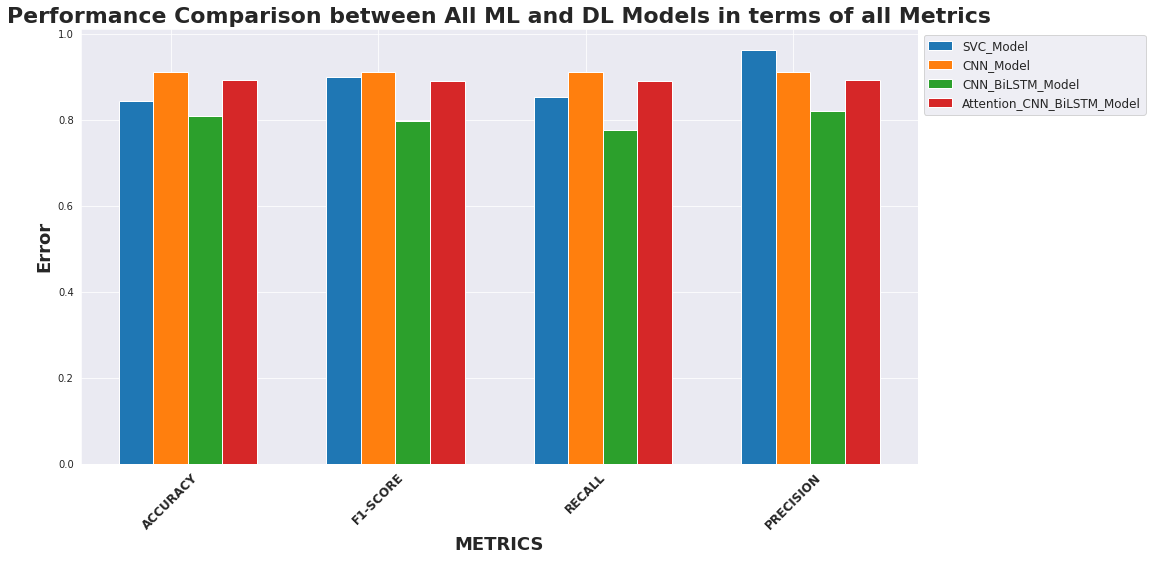

In [ ]:
"""
    Performance Comparison between All ML and DL Models in terms of all Metrics:
"""
SVC_Model = [0.8423, 0.8986, 0.8525, 0.9625]
CNN_Model = [0.9115, 0.9104, 0.9102, 0.9106]
CNN_BiLSTM_Model = [0.8080, 0.7966, 0.7748, 0.8204]
Attention_CNN_BiLSTM_Model = [0.8921, 0.8909, 0.8902, 0.8916]

N = 4
x = np.arange(N)
c = ['red', 'orange', 'blue', 'green']
width = 0.5

# Set position of bar on X axis
r1 = np.arange(0,len(CNN_Model) * 3, 3)
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
r4 = [x + width for x in r3]

plt.figure(figsize=(15, 8))
plt.ylabel("Error", weight='bold').set_fontsize('18')
plt.bar(r1, SVC_Model, width, edgecolor='white', label='SVC_Model')
plt.bar(r2, CNN_Model, width, edgecolor='white', label='CNN_Model')
plt.bar(r3, CNN_BiLSTM_Model, width, edgecolor='white', label='CNN_BiLSTM_Model')
plt.bar(r4, Attention_CNN_BiLSTM_Model, width, edgecolor='white', label='Attention_CNN_BiLSTM_Model')
plt.xlabel('METRICS', weight='bold').set_fontsize('18')
plt.xticks([r + width for r in range(0, len(SVC_Model) * 3, 3)], ['ACCURACY', 'F1-SCORE', 'RECALL', 'PRECISION'], rotation=45, size = 12, fontweight='bold')
plt.title('Performance Comparison between All ML and DL Models in terms of all Metrics', size = 22, fontweight='bold')
plt.legend(loc = 'best', bbox_to_anchor = (1.0, 1.0), ncol = 1, frameon=True, fontsize = '12')
plt.savefig('Performance Comparison between All ML and DL Models in terms of all Metrics.png')

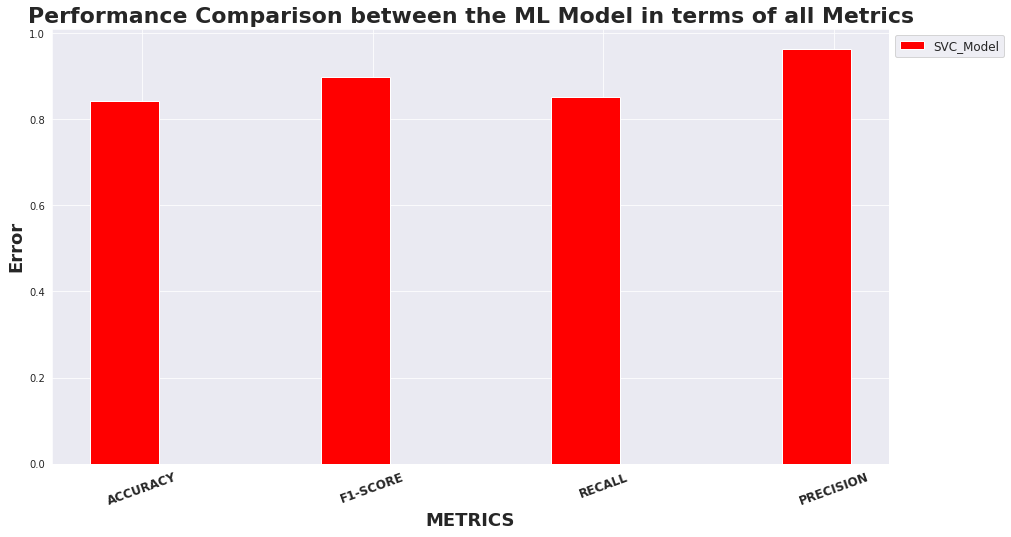

In [ ]:
"""
    Performance Comparison between All ML and DL Models in terms of all Metrics:
"""
SVC_Model = [0.8423, 0.8986, 0.8525, 0.9625]

N = 4
x = np.arange(N)
c = ['red']
width = 0.9

# Set position of bar on X axis
r1 = np.arange(0, len(CNN_Model) * 3, 3)

plt.figure(figsize=(15, 8))
plt.ylabel("Error", weight='bold').set_fontsize('18')
plt.bar(r1, SVC_Model, width, edgecolor='white', label='SVC_Model', color = 'red')
plt.xlabel('METRICS', weight='bold').set_fontsize('18')
plt.xticks([r + width/4 for r in range(0, len(SVC_Model) * 3, 3)], ['ACCURACY', 'F1-SCORE', 'RECALL', 'PRECISION'], rotation=20, size = 12, fontweight='bold')
plt.title('Performance Comparison between the ML Model in terms of all Metrics', size = 22, fontweight='bold')
plt.legend(loc = 'best', bbox_to_anchor = (1.0, 1.0), ncol = 1, frameon=True, fontsize = '12')
plt.savefig('Performance Comparison between the ML Model in terms of all Metrics.png')

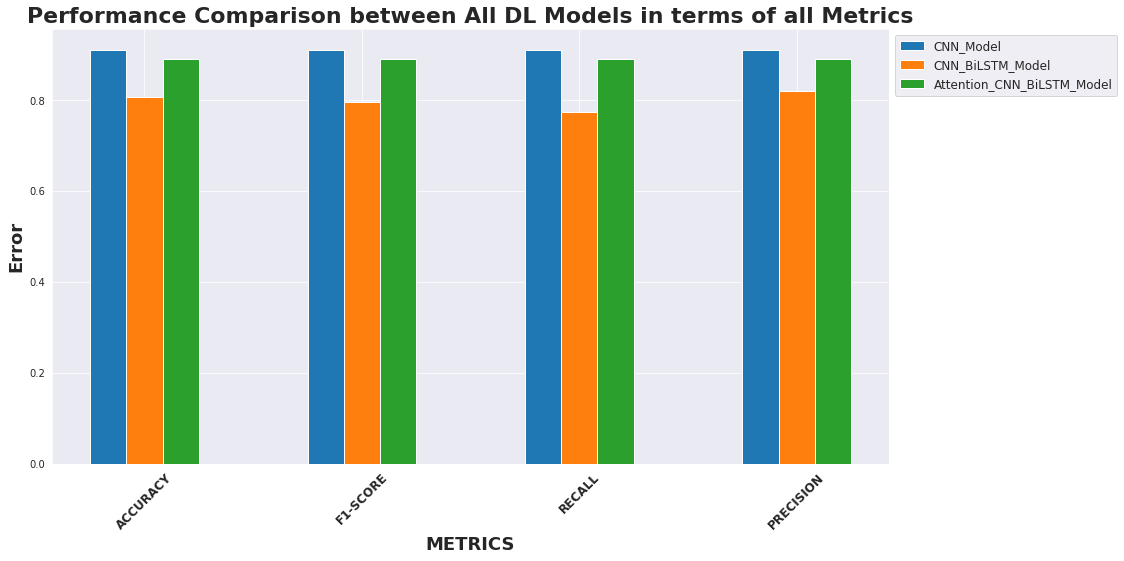

In [ ]:
"""
    Performance Comparison between All DL Models in terms of all Metrics:
"""
CNN_Model = [0.9115, 0.9104, 0.9102, 0.9106]
CNN_BiLSTM_Model = [0.8080, 0.7966, 0.7748, 0.8204]
Attention_CNN_BiLSTM_Model = [0.8921, 0.8909, 0.8902, 0.8916]

N = 4
x = np.arange(N)
c = ['red', 'blue', 'green']
width = 0.5

# Set position of bar on X axis
r1 = np.arange(0,len(CNN_Model) * 3, 3)
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

plt.figure(figsize=(15, 8))
plt.ylabel("Error", weight='bold').set_fontsize('18')
plt.bar(r1, CNN_Model, width, edgecolor='white', label='CNN_Model')
plt.bar(r2, CNN_BiLSTM_Model, width, edgecolor='white', label='CNN_BiLSTM_Model')
plt.bar(r3, Attention_CNN_BiLSTM_Model, width, edgecolor='white', label='Attention_CNN_BiLSTM_Model')
plt.xlabel('METRICS', weight='bold').set_fontsize('18')
plt.xticks([r + width for r in range(0, len(SVC_Model) * 3, 3)], ['ACCURACY', 'F1-SCORE', 'RECALL', 'PRECISION'], rotation=45, size = 12, fontweight='bold')
plt.title('Performance Comparison between All DL Models in terms of all Metrics', size = 22, fontweight='bold')
plt.legend(loc = 'best', bbox_to_anchor = (1.0, 1.0), ncol = 1, frameon=True, fontsize = '12')
plt.savefig('Performance Comparison between All DL Models in terms of all Metrics.png')